# Method 9 - Rest Ideas After 15

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 15].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

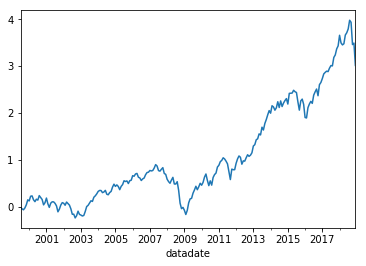

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.146295
2000-12-31   -0.053232
2001-12-31    0.001271
2002-12-31   -0.230181
2003-12-31    0.522289
2004-12-31    0.163009
2005-12-31    0.056062
2006-12-31    0.110070
2007-12-31   -0.026233
2008-12-31   -0.417045
2009-12-31    0.521955
2010-12-31    0.230445
2011-12-31   -0.030347
2012-12-31    0.201237
2013-12-31    0.418652
2014-12-31    0.083895
2015-12-31   -0.036764
2016-12-31    0.146080
2017-12-31    0.214148
2018-12-31   -0.094073
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2270.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.45e-183
Time:                        20:49:13   Log-Likelihood:                 789.60
No. Observations:                 234   AIC:                            -1569.
Df Residuals:                     229   BIC:                            -1552.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      4.557      0.000       0.001       0.004
mktrf          1.0307      0.016     65.983      0.000       1.000       1.061
me             0.3052      0.018     16.796      0.000       0.269       0.341
ia             0.0832      0.028      3.012      0.003       0.029       0.138
roe           -0.1960      0.024     -8.290      0.000      -0.243      -0.149
==============================================================================
Omnibus:                       26.049   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.050
Skew:                           0.224   Prob(JB):                     4.66e-25
Kurtosis:                       6.360   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1883.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.31e-174
Time:                        20:49:13   Log-Likelihood:                 789.60
No. Observations:                 234   AIC:                            -1569.
Df Residuals:                     229   BIC:                            -1552.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.637      0.000       0.001       0.004
mktrf          1.0307      0.019     55.012      0.000       0.994       1.067
me             0.3052      0.038      7.927      0.000       0.230       0.381
ia             0.0832      0.048      1.726      0.084      -0.011       0.178
roe           -0.1960      0.040     -4.872      0.000      -0.275      -0.117
==============================================================================
Omnibus:                       26.049   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.050
Skew:                           0.224   Prob(JB):                     4.66e-25
Kurtosis:                       6.360   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2341.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.05e-184
Time:                        20:49:13   Log-Likelihood:                 789.60
No. Observations:                 234   AIC:                            -1569.
Df Residuals:                     229   BIC:                            -1552.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.440      0.001       0.001       0.004
mktrf          1.0307      0.019     52.977      0.000       0.993       1.069
me             0.3052      0.039      7.800      0.000       0.229       0.382
ia             0.0832      0.045      1.868      0.062      -0.004       0.170
roe           -0.1960      0.043     -4.515      0.000      -0.281      -0.111
==============================================================================
Omnibus:                       26.049   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.050
Skew:                           0.224   Prob(JB):                     4.66e-25
Kurtosis:                       6.360   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1459.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.77e-171
Time:                        20:49:13   Log-Likelihood:                 765.21
No. Observations:                 234   AIC:                            -1518.
Df Residuals:                     228   BIC:                            -1498.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.093      0.002       0.001       0.003
mktrf          1.0691      0.017     61.414      0.000       1.035       1.103
smb            0.3552      0.023     15.463      0.000       0.310       0.400
hml            0.0591      0.027      2.181      0.030       0.006       0.112
rmw           -0.1052      0.031     -3.435      0.001      -0.166      -0.045
cma            0.0275      0.039      0.706      0.481      -0.049       0.104
==============================================================================
Omnibus:                       60.114   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.567
Skew:                           0.899   Prob(JB):                     2.42e-65
Kurtosis:                       8.224   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1351.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.42e-167
Time:                        20:49:14   Log-Likelihood:                 765.21
No. Observations:                 234   AIC:                            -1518.
Df Residuals:                     228   BIC:                            -1498.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.728      0.006       0.001       0.003
mktrf          1.0691      0.016     67.083      0.000       1.038       1.100
smb            0.3552      0.036      9.830      0.000       0.284       0.426
hml            0.0591      0.053      1.108      0.268      -0.045       0.164
rmw           -0.1052      0.045     -2.353      0.019      -0.193      -0.018
cma            0.0275      0.057      0.485      0.628      -0.084       0.139
==============================================================================
Omnibus:                       60.114   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.567
Skew:                           0.899   Prob(JB):                     2.42e-65
Kurtosis:                       8.224   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1652.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.63e-177
Time:                        20:49:14   Log-Likelihood:                 765.21
No. Observations:                 234   AIC:                            -1518.
Df Residuals:                     228   BIC:                            -1498.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.484      0.013       0.000       0.004
mktrf          1.0691      0.016     67.590      0.000       1.038       1.100
smb            0.3552      0.033     10.790      0.000       0.291       0.420
hml            0.0591      0.050      1.175      0.240      -0.039       0.158
rmw           -0.1052      0.050     -2.101      0.036      -0.203      -0.007
cma            0.0275      0.054      0.507      0.612      -0.079       0.134
==============================================================================
Omnibus:                       60.114   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              297.567
Skew:                           0.899   Prob(JB):                     2.42e-65
Kurtosis:                       8.224   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2137.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.57e-180
Time:                        20:49:14   Log-Likelihood:                 782.69
No. Observations:                 234   AIC:                            -1555.
Df Residuals:                     229   BIC:                            -1538.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.853      0.000       0.001       0.003
mktrf          1.0430      0.015     70.415      0.000       1.014       1.072
smb            0.4049      0.018     21.900      0.000       0.369       0.441
hml            0.0843      0.018      4.589      0.000       0.048       0.120
umd           -0.1041      0.012     -8.635      0.000      -0.128      -0.080
==============================================================================
Omnibus:                       17.859   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.196
Skew:                           0.121   Prob(JB):                     6.27e-13
Kurtosis:                       5.389   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1910.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.45e-174
Time:                        20:49:14   Log-Likelihood:                 782.69
No. Observations:                 234   AIC:                            -1555.
Df Residuals:                     229   BIC:                            -1538.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.982      0.003       0.001       0.004
mktrf          1.0430      0.016     63.343      0.000       1.011       1.075
smb            0.4049      0.025     15.910      0.000       0.355       0.455
hml            0.0843      0.045      1.868      0.062      -0.004       0.173
umd           -0.1041      0.021     -4.974      0.000      -0.145      -0.063
==============================================================================
Omnibus:                       17.859   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.196
Skew:                           0.121   Prob(JB):                     6.27e-13
Kurtosis:                       5.389   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2299.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.61e-183
Time:                        20:49:14   Log-Likelihood:                 782.69
No. Observations:                 234   AIC:                            -1555.
Df Residuals:                     229   BIC:                            -1538.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.712      0.007       0.001       0.004
mktrf          1.0430      0.014     73.780      0.000       1.015       1.071
smb            0.4049      0.026     15.386      0.000       0.353       0.457
hml            0.0843      0.048      1.739      0.082      -0.011       0.179
umd           -0.1041      0.018     -5.791      0.000      -0.139      -0.069
==============================================================================
Omnibus:                       17.859   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.196
Skew:                           0.121   Prob(JB):                     6.27e-13
Kurtosis:                       5.389   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     996.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.12e-88
Time:                        20:49:14   Log-Likelihood:                 382.98
No. Observations:                 120   AIC:                            -756.0
Df Residuals:                     115   BIC:                            -742.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.974      0.000       0.002       0.006
mktrf          1.0274      0.026     39.226      0.000       0.975       1.079
me             0.2713      0.026     10.486      0.000       0.220       0.322
ia             0.1251      0.041      3.089      0.003       0.045       0.205
roe           -0.2225      0.036     -6.206      0.000      -0.294      -0.151
==============================================================================
Omnibus:                        7.510   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               13.424
Skew:                           0.132   Prob(JB):                      0.00122
Kurtosis:                       4.617   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1343.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.71e-95
Time:                        20:49:14   Log-Likelihood:                 382.98
No. Observations:                 120   AIC:                            -756.0
Df Residuals:                     115   BIC:                            -742.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.110      0.002       0.001       0.006
mktrf          1.0274      0.027     38.273      0.000       0.975       1.080
me             0.2713      0.042      6.506      0.000       0.190       0.353
ia             0.1251      0.057      2.201      0.028       0.014       0.237
roe           -0.2225      0.048     -4.603      0.000      -0.317      -0.128
==============================================================================
Omnibus:                        7.510   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               13.424
Skew:                           0.132   Prob(JB):                      0.00122
Kurtosis:                       4.617   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2230.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.13e-108
Time:                        20:49:14   Log-Likelihood:                 382.98
No. Observations:                 120   AIC:                            -756.0
Df Residuals:                     115   BIC:                            -742.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      2.821      0.005       0.001       0.007
mktrf          1.0274      0.027     38.485      0.000       0.975       1.080
me             0.2713      0.044      6.155      0.000       0.185       0.358
ia             0.1251      0.047      2.650      0.008       0.033       0.218
roe           -0.2225      0.051     -4.345      0.000      -0.323      -0.122
==============================================================================
Omnibus:                        7.510   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               13.424
Skew:                           0.132   Prob(JB):                      0.00122
Kurtosis:                       4.617   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     618.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.25e-81
Time:                        20:49:14   Log-Likelihood:                 368.68
No. Observations:                 120   AIC:                            -725.4
Df Residuals:                     114   BIC:                            -708.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.234      0.002       0.001       0.006
mktrf          1.1191      0.031     35.813      0.000       1.057       1.181
smb            0.3491      0.035      9.863      0.000       0.279       0.419
hml            0.0354      0.043      0.816      0.416      -0.051       0.121
rmw           -0.0691      0.051     -1.352      0.179      -0.170       0.032
cma            0.0890      0.056      1.589      0.115      -0.022       0.200
==============================================================================
Omnibus:                       23.240   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.029
Skew:                           0.675   Prob(JB):                     3.39e-14
Kurtosis:                       6.253   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     842.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.10e-88
Time:                        20:49:14   Log-Likelihood:                 368.68
No. Observations:                 120   AIC:                            -725.4
Df Residuals:                     114   BIC:                            -708.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.849      0.004       0.001       0.006
mktrf          1.1191      0.027     40.987      0.000       1.066       1.173
smb            0.3491      0.050      6.992      0.000       0.251       0.447
hml            0.0354      0.083      0.425      0.671      -0.128       0.199
rmw           -0.0691      0.067     -1.035      0.301      -0.200       0.062
cma            0.0890      0.067      1.337      0.181      -0.041       0.220
==============================================================================
Omnibus:                       23.240   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.029
Skew:                           0.675   Prob(JB):                     3.39e-14
Kurtosis:                       6.253   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1379.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.59e-100
Time:                        20:49:14   Log-Likelihood:                 368.68
No. Observations:                 120   AIC:                            -725.4
Df Residuals:                     114   BIC:                            -708.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.601      0.009       0.001       0.006
mktrf          1.1191      0.025     44.159      0.000       1.069       1.169
smb            0.3491      0.046      7.521      0.000       0.258       0.440
hml            0.0354      0.082      0.434      0.664      -0.125       0.195
rmw           -0.0691      0.073     -0.947      0.344      -0.212       0.074
cma            0.0890      0.063      1.422      0.155      -0.034       0.212
==============================================================================
Omnibus:                       23.240   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.029
Skew:                           0.675   Prob(JB):                     3.39e-14
Kurtosis:                       6.253   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     962.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.21e-87
Time:                        20:49:14   Log-Likelihood:                 380.94
No. Observations:                 120   AIC:                            -751.9
Df Residuals:                     115   BIC:                            -737.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      4.034      0.000       0.002       0.006
mktrf          1.0541      0.023     44.915      0.000       1.008       1.101
smb            0.4058      0.027     15.187      0.000       0.353       0.459
hml            0.1037      0.027      3.874      0.000       0.051       0.157
umd           -0.1110      0.017     -6.729      0.000      -0.144      -0.078
==============================================================================
Omnibus:                        6.290   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.043   Jarque-Bera (JB):               10.405
Skew:                          -0.050   Prob(JB):                      0.00550
Kurtosis:                       4.439   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1122.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.18e-91
Time:                        20:49:14   Log-Likelihood:                 380.94
No. Observations:                 120   AIC:                            -751.9
Df Residuals:                     115   BIC:                            -737.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.618      0.000       0.002       0.006
mktrf          1.0541      0.026     40.401      0.000       1.003       1.105
smb            0.4058      0.032     12.653      0.000       0.343       0.469
hml            0.1037      0.061      1.693      0.090      -0.016       0.224
umd           -0.1110      0.024     -4.707      0.000      -0.157      -0.065
==============================================================================
Omnibus:                        6.290   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.043   Jarque-Bera (JB):               10.405
Skew:                          -0.050   Prob(JB):                      0.00550
Kurtosis:                       4.439   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1438.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.72e-97
Time:                        20:49:14   Log-Likelihood:                 380.94
No. Observations:                 120   AIC:                            -751.9
Df Residuals:                     115   BIC:                            -737.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.338      0.001       0.002       0.006
mktrf          1.0541      0.021     49.199      0.000       1.012       1.096
smb            0.4058      0.035     11.722      0.000       0.338       0.474
hml            0.1037      0.065      1.588      0.112      -0.024       0.232
umd           -0.1110      0.020     -5.573      0.000      -0.150      -0.072
==============================================================================
Omnibus:                        6.290   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.043   Jarque-Bera (JB):               10.405
Skew:                          -0.050   Prob(JB):                      0.00550
Kurtosis:                       4.439   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2041.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.84e-101
Time:                        20:49:14   Log-Likelihood:                 439.99
No. Observations:                 114   AIC:                            -870.0
Df Residuals:                     109   BIC:                            -856.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.923      0.004       0.000       0.003
mktrf          1.0274      0.015     67.002      0.000       0.997       1.058
me             0.3832      0.024     16.187      0.000       0.336       0.430
ia            -0.0401      0.033     -1.221      0.225      -0.105       0.025
roe           -0.1792      0.029     -6.210      0.000      -0.236      -0.122
==============================================================================
Omnibus:                        5.947   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.532
Skew:                          -0.528   Prob(JB):                       0.0629
Kurtosis:                       3.219   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3311.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.64e-113
Time:                        20:49:14   Log-Likelihood:                 439.99
No. Observations:                 114   AIC:                            -870.0
Df Residuals:                     109   BIC:                            -856.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.491      0.000       0.001       0.002
mktrf          1.0274      0.013     76.700      0.000       1.001       1.054
me             0.3832      0.019     20.265      0.000       0.346       0.420
ia            -0.0401      0.031     -1.301      0.193      -0.100       0.020
roe           -0.1792      0.023     -7.880      0.000      -0.224      -0.135
==============================================================================
Omnibus:                        5.947   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.532
Skew:                          -0.528   Prob(JB):                       0.0629
Kurtosis:                       3.219   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     4651.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.89e-121
Time:                        20:49:14   Log-Likelihood:                 439.99
No. Observations:                 114   AIC:                            -870.0
Df Residuals:                     109   BIC:                            -856.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.865      0.000       0.001       0.002
mktrf          1.0274      0.013     80.336      0.000       1.002       1.052
me             0.3832      0.018     21.271      0.000       0.348       0.419
ia            -0.0401      0.034     -1.169      0.243      -0.107       0.027
roe           -0.1792      0.020     -8.895      0.000      -0.219      -0.140
==============================================================================
Omnibus:                        5.947   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.532
Skew:                          -0.528   Prob(JB):                       0.0629
Kurtosis:                       3.219   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1813.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.05e-102
Time:                        20:49:14   Log-Likelihood:                 446.40
No. Observations:                 114   AIC:                            -880.8
Df Residuals:                     108   BIC:                            -864.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.082      0.282      -0.000       0.002
mktrf          1.0384      0.014     74.769      0.000       1.011       1.066
smb            0.3579      0.023     15.872      0.000       0.313       0.403
hml            0.0379      0.029      1.316      0.191      -0.019       0.095
rmw           -0.2231      0.035     -6.337      0.000      -0.293      -0.153
cma           -0.0800      0.045     -1.789      0.076      -0.169       0.009
==============================================================================
Omnibus:                        6.793   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.397
Skew:                          -0.486   Prob(JB):                       0.0408
Kurtosis:                       3.634   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2149.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.33e-106
Time:                        20:49:14   Log-Likelihood:                 446.40
No. Observations:                 114   AIC:                            -880.8
Df Residuals:                     108   BIC:                            -864.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.160      0.246      -0.000       0.001
mktrf          1.0384      0.012     89.585      0.000       1.016       1.061
smb            0.3579      0.019     18.424      0.000       0.320       0.396
hml            0.0379      0.034      1.128      0.259      -0.028       0.104
rmw           -0.2231      0.032     -6.938      0.000      -0.286      -0.160
cma           -0.0800      0.043     -1.874      0.061      -0.164       0.004
==============================================================================
Omnibus:                        6.793   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.397
Skew:                          -0.486   Prob(JB):                       0.0408
Kurtosis:                       3.634   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3015.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.16e-114
Time:                        20:49:14   Log-Likelihood:                 446.40
No. Observations:                 114   AIC:                            -880.8
Df Residuals:                     108   BIC:                            -864.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      1.071      0.284      -0.000       0.002
mktrf          1.0384      0.010    103.927      0.000       1.019       1.058
smb            0.3579      0.018     19.597      0.000       0.322       0.394
hml            0.0379      0.035      1.082      0.279      -0.031       0.106
rmw           -0.2231      0.030     -7.542      0.000      -0.281      -0.165
cma           -0.0800      0.043     -1.870      0.061      -0.164       0.004
==============================================================================
Omnibus:                        6.793   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.397
Skew:                          -0.486   Prob(JB):                       0.0408
Kurtosis:                       3.634   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1730.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-97
Time:                        20:49:14   Log-Likelihood:                 430.72
No. Observations:                 114   AIC:                            -851.4
Df Residuals:                     109   BIC:                            -837.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.379      0.705      -0.001       0.001
mktrf          1.0495      0.016     66.581      0.000       1.018       1.081
smb            0.4117      0.025     16.751      0.000       0.363       0.460
hml            0.0314      0.025      1.239      0.218      -0.019       0.082
umd           -0.0692      0.019     -3.624      0.000      -0.107      -0.031
==============================================================================
Omnibus:                        7.485   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.353
Skew:                          -0.494   Prob(JB):                       0.0253
Kurtosis:                       3.757   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1821.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.49e-99
Time:                        20:49:14   Log-Likelihood:                 430.72
No. Observations:                 114   AIC:                            -851.4
Df Residuals:                     109   BIC:                            -837.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.405      0.685      -0.001       0.001
mktrf          1.0495      0.015     70.391      0.000       1.020       1.079
smb            0.4117      0.023     18.079      0.000       0.367       0.456
hml            0.0314      0.033      0.944      0.345      -0.034       0.097
umd           -0.0692      0.018     -3.872      0.000      -0.104      -0.034
==============================================================================
Omnibus:                        7.485   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.353
Skew:                          -0.494   Prob(JB):                       0.0253
Kurtosis:                       3.757   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3570.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.47e-114
Time:                        20:49:14   Log-Likelihood:                 430.72
No. Observations:                 114   AIC:                            -851.4
Df Residuals:                     109   BIC:                            -837.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.397      0.692      -0.001       0.001
mktrf          1.0495      0.013     78.058      0.000       1.023       1.076
smb            0.4117      0.017     23.609      0.000       0.378       0.446
hml            0.0314      0.034      0.930      0.352      -0.035       0.097
umd           -0.0692      0.016     -4.317      0.000      -0.101      -0.038
==============================================================================
Omnibus:                        7.485   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.353
Skew:                          -0.494   Prob(JB):                       0.0253
Kurtosis:                       3.757   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""